In [28]:
!pip install selenium
!pip install beautifulsoup4
!pip install selenium webdriver-manager
!pip install matplotlib seaborn

In [33]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import requests
import csv
import time
import os

VERBOSE = 0 ### TURN THIS ON AT NIGHT AND LEAVE IT RUNNING 




class Business:
    def __init__(self, name, link):
        self.name = name
        self.link = link
        self.vc = 0
        self.localVotes = 0
        self.otherVotes = 0
    
    def __repr__(self):
        return f"Business(name={self.name}, link={self.link})"

bigDict = {}
    
def scrapeBusiness(business):
    appendix = ""
    vc = 0
    upperLimit = 0
    r1 = requests.get('https://'+business.link+appendix)
    if(r1.status_code == 200 and VERBOSE == 1): # Calculate upper limit for ALL reviews (big long time no fun)
        tmpSoup = BeautifulSoup(r1.content,'html.parser')
        
        tmp = tmpSoup.find('div',class_='css-1aq64zd')
        upperLimit = int(tmp.text.split(" ")[-1])

        
        
        ##upperLimit = int(tmp.text.split(" ")[-1])
    else:
        upperLimit = 10 # Set the default upper limit to 100 reviews, saves time + sanity 
    for i in range(upperLimit-1):
        reviews = []
        init = time.time()
        session = requests.Session()
        response = session.get('https://'+business.link+appendix)
        #response = requests.get('https://'+business.link+appendix)
        post = time.time()
        #print("TO GET ",post-init)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            reviews = soup.find_all('li', class_='css-1q2nwpv')
#             if(len(reviews) == 0):
#                 reviews = soup.find_all('li', class_='css-1q2nwpv')
            for review in reviews:
                ls = review.find('span', class_='css-qgunke')
                name = review.find('a', class_='css-19v1rkv')
                
                rd = review.find('div', class_='css-14g69b3')
                if ls and rd:
                    state = ls.text.split(',')[-1].strip()
                    rating = rd['aria-label'][0]
                    if state == "AZ":
                        business.localVotes += int(rating)
                    else:
                        business.otherVotes += int(rating)
                    
                    if(name != None):
                        if name.text in bigDict:
                            if (business.name, rating) not in bigDict[name.text]:
                                bigDict[name.text].append((business.name, rating))
                        else:
                            bigDict[name.text] = [(business.name, rating)]
                    vc += 1
                    #print(state, rating)
            business.vc = vc
            #print("[Debug]",business.localVotes, business.otherVotes, business.vc)
            appendix = f"?start={i*10}"
            final = time.time()
            #print("TO END", final-post)
                
    
    
    
####################################################################33 css-14g69b3
url = 'https://www.yelp.com/search?find_loc=Tucson%2C+AZ'
allBusiness = []
pn = 1
entry = 1
for i in range(2): # Range is num pages of rests
    page = requests.get(url)
    
    soup = BeautifulSoup(page.text, 'html.parser')  
    items = soup.find_all('a', class_='css-19v1rkv')
    for item in items:
        #print(entry)
        toAdd = Business(item.get('name'), "www.yelp.com"+item.get('href'))
        allBusiness.append(toAdd)
        entry +=1
    
    links = soup.find_all('a',attrs={'href': True})
    # All the stupid shit to move pages. pn * Range should total the number of entries 
    for link in links:
        href_val = link.get('href')
        target = f"https://www.yelp.com/search?find_loc=Tucson%2C+AZ&start={pn*10}"
        if(target == href_val):
            #print("HAPPENS")
            url = href_val
            pn +=1


csv_file = './business_results.csv'
file_exists = os.path.isfile(csv_file) and os.path.getsize(csv_file) > 0

with open(csv_file, mode='a', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    if not file_exists:
        writer.writerow(['Business Name', 'Link', 'Local Votes', 'Other Votes', 'Total Votes'])
    
    
    for business in allBusiness:
        print("BUSINESS : ", business.name)
        scrapeBusiness(business)
        #if business.vc == 0:  # Business not filled; Retry. Hope it doesn't happen a second time.
        #    scrapeBusiness(business)
        #print("Local Votes, Others, #", business.localVotes, business.otherVotes, business.vc)
        #print("DICT",bigDict)
        for entry in bigDict:
            if len(bigDict[entry]) > 1:
                print(entry, bigDict[entry])
        writer.writerow([business.name, business.link, business.localVotes, business.otherVotes, business.vc])
    
    
#print(items)


BUSINESS :  Culinary Dropout
BUSINESS :  Tito & Pep
James B. [('Culinary Dropout', '2'), ('Tito & Pep', '4')]
Amy C. [('Culinary Dropout', '5'), ('Tito & Pep', '5')]
BUSINESS :  The Parish
Daniel C. [('Culinary Dropout', '5'), ('The Parish', '3')]
Mandy T. [('Culinary Dropout', '3'), ('The Parish', '3')]
James B. [('Culinary Dropout', '2'), ('Tito & Pep', '4')]
Amy C. [('Culinary Dropout', '5'), ('Tito & Pep', '5'), ('The Parish', '5')]
Jodi G. [('Culinary Dropout', '4'), ('The Parish', '5')]
Tamara M. [('Culinary Dropout', '5'), ('The Parish', '5')]
Rebecca I. [('Tito & Pep', '5'), ('The Parish', '4')]
Sandy S. [('The Parish', '5'), ('The Parish', '4')]
BUSINESS :  Tumerico
Daniel C. [('Culinary Dropout', '5'), ('The Parish', '3')]
Mandy T. [('Culinary Dropout', '3'), ('The Parish', '3')]
James B. [('Culinary Dropout', '2'), ('Tito & Pep', '4')]
Amy C. [('Culinary Dropout', '5'), ('Tito & Pep', '5'), ('The Parish', '5')]
Jodi G. [('Culinary Dropout', '4'), ('The Parish', '5')]
Tamara 

Daniel C. [('Culinary Dropout', '5'), ('The Parish', '3')]
Elizabeth O. [('Culinary Dropout', '3'), ('Postino Grant', '4')]
Marissa M. [('Culinary Dropout', '5'), ('Postino Grant', '5')]
Mandy T. [('Culinary Dropout', '3'), ('The Parish', '3'), ('Mojo Cuban Kitchen and Rum Bar', '5'), ('Postino Grant', '4')]
James B. [('Culinary Dropout', '2'), ('Tito & Pep', '4'), ('Fleming’s Prime Steakhouse & Wine Bar', '3')]
Andrea T. [('Culinary Dropout', '4'), ('Mojo Cuban Kitchen and Rum Bar', '4')]
Amy C. [('Culinary Dropout', '5'), ('Tito & Pep', '5'), ('The Parish', '5'), ('Postino Grant', '5')]
Assal U. [('Culinary Dropout', '5'), ('Postino Grant', '5'), ('Prep & Pastry', '4')]
Belle V. [('Culinary Dropout', '4'), ('Mojo Cuban Kitchen and Rum Bar', '5')]
Steve V. [('Culinary Dropout', '3'), ('Prep & Pastry', '4')]
Kiara R. [('Culinary Dropout', '4'), ('Mojo Cuban Kitchen and Rum Bar', '5')]
Jodi G. [('Culinary Dropout', '4'), ('The Parish', '5')]
Jocelyn S. [('Culinary Dropout', '4'), ('Mojo

Daniel C. [('Culinary Dropout', '5'), ('The Parish', '3'), ('Charro Steak & Del Rey', '4')]
Elizabeth O. [('Culinary Dropout', '3'), ('Postino Grant', '4')]
Marissa M. [('Culinary Dropout', '5'), ('Postino Grant', '5')]
Chelsea J. [('Culinary Dropout', '4'), ('El Chinito Gordo', '5')]
Mandy T. [('Culinary Dropout', '3'), ('The Parish', '3'), ('Mojo Cuban Kitchen and Rum Bar', '5'), ('Postino Grant', '4')]
James B. [('Culinary Dropout', '2'), ('Tito & Pep', '4'), ('Fleming’s Prime Steakhouse & Wine Bar', '3'), ('Charro Steak & Del Rey', '5')]
Ashley C. [('Culinary Dropout', '4'), ('El Chinito Gordo', '4')]
Andrea T. [('Culinary Dropout', '4'), ('Mojo Cuban Kitchen and Rum Bar', '4')]
Amy C. [('Culinary Dropout', '5'), ('Tito & Pep', '5'), ('The Parish', '5'), ('Postino Grant', '5')]
Assal U. [('Culinary Dropout', '5'), ('Postino Grant', '5'), ('Prep & Pastry', '4')]
Belle V. [('Culinary Dropout', '4'), ('Mojo Cuban Kitchen and Rum Bar', '5')]
Steve V. [('Culinary Dropout', '3'), ('Prep 

Daniel C. [('Culinary Dropout', '5'), ('The Parish', '3'), ('Charro Steak & Del Rey', '4')]
Elizabeth O. [('Culinary Dropout', '3'), ('Postino Grant', '4')]
Marissa M. [('Culinary Dropout', '5'), ('Postino Grant', '5'), ('Kazoku', '5')]
Chelsea J. [('Culinary Dropout', '4'), ('El Chinito Gordo', '5')]
Mandy T. [('Culinary Dropout', '3'), ('The Parish', '3'), ('Mojo Cuban Kitchen and Rum Bar', '5'), ('Postino Grant', '4'), ('Kazoku', '4')]
James B. [('Culinary Dropout', '2'), ('Tito & Pep', '4'), ('Fleming’s Prime Steakhouse & Wine Bar', '3'), ('Charro Steak & Del Rey', '5')]
Ashley C. [('Culinary Dropout', '4'), ('El Chinito Gordo', '4')]
Andrea T. [('Culinary Dropout', '4'), ('Mojo Cuban Kitchen and Rum Bar', '4')]
Amy C. [('Culinary Dropout', '5'), ('Tito & Pep', '5'), ('The Parish', '5'), ('Postino Grant', '5')]
Assal U. [('Culinary Dropout', '5'), ('Postino Grant', '5'), ('Prep & Pastry', '4')]
Belle V. [('Culinary Dropout', '4'), ('Mojo Cuban Kitchen and Rum Bar', '5')]
Steve V. [

Daniel C. [('Culinary Dropout', '5'), ('The Parish', '3'), ('Charro Steak & Del Rey', '4')]
Elizabeth O. [('Culinary Dropout', '3'), ('Postino Grant', '4')]
Marissa M. [('Culinary Dropout', '5'), ('Postino Grant', '5'), ('Kazoku', '5')]
Chelsea J. [('Culinary Dropout', '4'), ('El Chinito Gordo', '5')]
Mandy T. [('Culinary Dropout', '3'), ('The Parish', '3'), ('Mojo Cuban Kitchen and Rum Bar', '5'), ('Postino Grant', '4'), ('Kazoku', '4'), ('Ginza Sushi', '4')]
James B. [('Culinary Dropout', '2'), ('Tito & Pep', '4'), ('Fleming’s Prime Steakhouse & Wine Bar', '3'), ('Charro Steak & Del Rey', '5')]
Ashley C. [('Culinary Dropout', '4'), ('El Chinito Gordo', '4')]
Andrea T. [('Culinary Dropout', '4'), ('Mojo Cuban Kitchen and Rum Bar', '4'), ('Ginza Sushi', '5')]
Amy C. [('Culinary Dropout', '5'), ('Tito & Pep', '5'), ('The Parish', '5'), ('Postino Grant', '5')]
Assal U. [('Culinary Dropout', '5'), ('Postino Grant', '5'), ('Prep & Pastry', '4')]
Belle V. [('Culinary Dropout', '4'), ('Mojo 

Daniel C. [('Culinary Dropout', '5'), ('The Parish', '3'), ('Charro Steak & Del Rey', '4')]
Elizabeth O. [('Culinary Dropout', '3'), ('Postino Grant', '4')]
Marissa M. [('Culinary Dropout', '5'), ('Postino Grant', '5'), ('Kazoku', '5')]
Chelsea J. [('Culinary Dropout', '4'), ('El Chinito Gordo', '5'), ('Rollies Mexican Patio', '5')]
Mandy T. [('Culinary Dropout', '3'), ('The Parish', '3'), ('Mojo Cuban Kitchen and Rum Bar', '5'), ('Postino Grant', '4'), ('Kazoku', '4'), ('Ginza Sushi', '4')]
James B. [('Culinary Dropout', '2'), ('Tito & Pep', '4'), ('Fleming’s Prime Steakhouse & Wine Bar', '3'), ('Charro Steak & Del Rey', '5')]
Ashley C. [('Culinary Dropout', '4'), ('El Chinito Gordo', '4')]
Andrea T. [('Culinary Dropout', '4'), ('Mojo Cuban Kitchen and Rum Bar', '4'), ('Ginza Sushi', '5')]
Amy C. [('Culinary Dropout', '5'), ('Tito & Pep', '5'), ('The Parish', '5'), ('Postino Grant', '5')]
Assal U. [('Culinary Dropout', '5'), ('Postino Grant', '5'), ('Prep & Pastry', '4')]
Belle V. [('

Daniel C. [('Culinary Dropout', '5'), ('The Parish', '3'), ('Charro Steak & Del Rey', '4')]
Elizabeth O. [('Culinary Dropout', '3'), ('Postino Grant', '4')]
Marissa M. [('Culinary Dropout', '5'), ('Postino Grant', '5'), ('Kazoku', '5')]
Chelsea J. [('Culinary Dropout', '4'), ('El Chinito Gordo', '5'), ('Rollies Mexican Patio', '5')]
Mandy T. [('Culinary Dropout', '3'), ('The Parish', '3'), ('Mojo Cuban Kitchen and Rum Bar', '5'), ('Postino Grant', '4'), ('Kazoku', '4'), ('Ginza Sushi', '4')]
James B. [('Culinary Dropout', '2'), ('Tito & Pep', '4'), ('Fleming’s Prime Steakhouse & Wine Bar', '3'), ('Charro Steak & Del Rey', '5')]
Ashley C. [('Culinary Dropout', '4'), ('El Chinito Gordo', '4')]
Andrea T. [('Culinary Dropout', '4'), ('Mojo Cuban Kitchen and Rum Bar', '4'), ('Ginza Sushi', '5')]
Amy C. [('Culinary Dropout', '5'), ('Tito & Pep', '5'), ('The Parish', '5'), ('Postino Grant', '5')]
Assal U. [('Culinary Dropout', '5'), ('Postino Grant', '5'), ('Prep & Pastry', '4')]
Belle V. [('

Daniel C. [('Culinary Dropout', '5'), ('The Parish', '3'), ('Charro Steak & Del Rey', '4')]
Elizabeth O. [('Culinary Dropout', '3'), ('Postino Grant', '4')]
Marissa M. [('Culinary Dropout', '5'), ('Postino Grant', '5'), ('Kazoku', '5')]
Chelsea J. [('Culinary Dropout', '4'), ('El Chinito Gordo', '5'), ('Rollies Mexican Patio', '5')]
Mandy T. [('Culinary Dropout', '3'), ('The Parish', '3'), ('Mojo Cuban Kitchen and Rum Bar', '5'), ('Postino Grant', '4'), ('Kazoku', '4'), ('Ginza Sushi', '4')]
James C. [('Culinary Dropout', '4'), ('Seis Kitchen', '4')]
James B. [('Culinary Dropout', '2'), ('Tito & Pep', '4'), ('Fleming’s Prime Steakhouse & Wine Bar', '3'), ('Charro Steak & Del Rey', '5')]
Ashley C. [('Culinary Dropout', '4'), ('El Chinito Gordo', '4')]
Andrea T. [('Culinary Dropout', '4'), ('Mojo Cuban Kitchen and Rum Bar', '4'), ('Ginza Sushi', '5')]
Amy C. [('Culinary Dropout', '5'), ('Tito & Pep', '5'), ('The Parish', '5'), ('Postino Grant', '5')]
Assal U. [('Culinary Dropout', '5'), 

Daniel C. [('Culinary Dropout', '5'), ('The Parish', '3'), ('Charro Steak & Del Rey', '4')]
Elizabeth O. [('Culinary Dropout', '3'), ('Postino Grant', '4')]
Marissa M. [('Culinary Dropout', '5'), ('Postino Grant', '5'), ('Kazoku', '5')]
Chelsea J. [('Culinary Dropout', '4'), ('El Chinito Gordo', '5'), ('Rollies Mexican Patio', '5')]
Mandy T. [('Culinary Dropout', '3'), ('The Parish', '3'), ('Mojo Cuban Kitchen and Rum Bar', '5'), ('Postino Grant', '4'), ('Kazoku', '4'), ('Ginza Sushi', '4'), ('American Eat', '4')]
James C. [('Culinary Dropout', '4'), ('Seis Kitchen', '4')]
James B. [('Culinary Dropout', '2'), ('Tito & Pep', '4'), ('Fleming’s Prime Steakhouse & Wine Bar', '3'), ('Charro Steak & Del Rey', '5')]
Ashley C. [('Culinary Dropout', '4'), ('El Chinito Gordo', '4')]
Andrea T. [('Culinary Dropout', '4'), ('Mojo Cuban Kitchen and Rum Bar', '4'), ('Ginza Sushi', '5')]
Amy C. [('Culinary Dropout', '5'), ('Tito & Pep', '5'), ('The Parish', '5'), ('Postino Grant', '5')]
Assal U. [('Cu

Daniel C. [('Culinary Dropout', '5'), ('The Parish', '3'), ('Charro Steak & Del Rey', '4')]
Elizabeth O. [('Culinary Dropout', '3'), ('Postino Grant', '4')]
Marissa M. [('Culinary Dropout', '5'), ('Postino Grant', '5'), ('Kazoku', '5')]
Chelsea J. [('Culinary Dropout', '4'), ('El Chinito Gordo', '5'), ('Rollies Mexican Patio', '5')]
Mandy T. [('Culinary Dropout', '3'), ('The Parish', '3'), ('Mojo Cuban Kitchen and Rum Bar', '5'), ('Postino Grant', '4'), ('Kazoku', '4'), ('Ginza Sushi', '4'), ('American Eat', '4')]
James C. [('Culinary Dropout', '4'), ('Seis Kitchen', '4')]
James B. [('Culinary Dropout', '2'), ('Tito & Pep', '4'), ('Fleming’s Prime Steakhouse & Wine Bar', '3'), ('Charro Steak & Del Rey', '5')]
Ashley C. [('Culinary Dropout', '4'), ('El Chinito Gordo', '4'), ('Locale Neighborhood Italian', '2')]
Andrea T. [('Culinary Dropout', '4'), ('Mojo Cuban Kitchen and Rum Bar', '4'), ('Ginza Sushi', '5')]
Amy C. [('Culinary Dropout', '5'), ('Tito & Pep', '5'), ('The Parish', '5'), 

Daniel C. [('Culinary Dropout', '5'), ('The Parish', '3'), ('Charro Steak & Del Rey', '4')]
Elizabeth O. [('Culinary Dropout', '3'), ('Postino Grant', '4')]
Marissa M. [('Culinary Dropout', '5'), ('Postino Grant', '5'), ('Kazoku', '5')]
Chelsea J. [('Culinary Dropout', '4'), ('El Chinito Gordo', '5'), ('Rollies Mexican Patio', '5')]
Mandy T. [('Culinary Dropout', '3'), ('The Parish', '3'), ('Mojo Cuban Kitchen and Rum Bar', '5'), ('Postino Grant', '4'), ('Kazoku', '4'), ('Ginza Sushi', '4'), ('American Eat', '4'), ('Polish Cottage', '3')]
James C. [('Culinary Dropout', '4'), ('Seis Kitchen', '4')]
James B. [('Culinary Dropout', '2'), ('Tito & Pep', '4'), ('Fleming’s Prime Steakhouse & Wine Bar', '3'), ('Charro Steak & Del Rey', '5'), ('Polish Cottage', '4')]
Ashley C. [('Culinary Dropout', '4'), ('El Chinito Gordo', '4'), ('Locale Neighborhood Italian', '2')]
Andrea T. [('Culinary Dropout', '4'), ('Mojo Cuban Kitchen and Rum Bar', '4'), ('Ginza Sushi', '5')]
Amy C. [('Culinary Dropout'

Daniel C. [('Culinary Dropout', '5'), ('The Parish', '3'), ('Charro Steak & Del Rey', '4')]
Elizabeth O. [('Culinary Dropout', '3'), ('Postino Grant', '4')]
Marissa M. [('Culinary Dropout', '5'), ('Postino Grant', '5'), ('Kazoku', '5')]
Chelsea J. [('Culinary Dropout', '4'), ('El Chinito Gordo', '5'), ('Rollies Mexican Patio', '5')]
Mandy T. [('Culinary Dropout', '3'), ('The Parish', '3'), ('Mojo Cuban Kitchen and Rum Bar', '5'), ('Postino Grant', '4'), ('Kazoku', '4'), ('Ginza Sushi', '4'), ('American Eat', '4'), ('Polish Cottage', '3')]
James C. [('Culinary Dropout', '4'), ('Seis Kitchen', '4')]
James B. [('Culinary Dropout', '2'), ('Tito & Pep', '4'), ('Fleming’s Prime Steakhouse & Wine Bar', '3'), ('Charro Steak & Del Rey', '5'), ('Polish Cottage', '4')]
Ashley C. [('Culinary Dropout', '4'), ('El Chinito Gordo', '4'), ('Locale Neighborhood Italian', '2')]
Andrea T. [('Culinary Dropout', '4'), ('Mojo Cuban Kitchen and Rum Bar', '4'), ('Ginza Sushi', '5')]
Amy C. [('Culinary Dropout'

In [34]:
print("buffer")
save_dict_to_json(bigDict, 'dict.json')

buffer


In [22]:
import json

def save_dict_to_json(dictionary, filepath):
    with open(filepath, 'a') as file:
        json.dump(dictionary, file)

def load_dict_from_json(filepath):
    with open(filepath, 'r') as file:
        return json.load(file)

# Save
save_dict_to_json(bigDict, 'dict.json')

# Load
scores = load_dict_from_json('dict.json')
print(scores)



{}


In [35]:
scores = load_dict_from_json('dict.json')
print(scores)

{'Haley B.': [['Culinary Dropout', '5']], 'Bill S.': [['Culinary Dropout', '5']], 'Michele C.': [['Culinary Dropout', '3']], 'Daniel C.': [['Culinary Dropout', '5'], ['The Parish', '3'], ['Charro Steak & Del Rey', '4']], 'Kersten L.': [['Culinary Dropout', '1']], 'Elizabeth O.': [['Culinary Dropout', '3'], ['Postino Grant', '4']], 'Marissa M.': [['Culinary Dropout', '5'], ['Postino Grant', '5'], ['Kazoku', '5']], 'Chelsea J.': [['Culinary Dropout', '4'], ['El Chinito Gordo', '5'], ['Rollies Mexican Patio', '5']], 'Mandy T.': [['Culinary Dropout', '3'], ['The Parish', '3'], ['Mojo Cuban Kitchen and Rum Bar', '5'], ['Postino Grant', '4'], ['Kazoku', '4'], ['Ginza Sushi', '4'], ['American Eat', '4'], ['Polish Cottage', '3']], 'Stacie L.': [['Culinary Dropout', '5']], 'Claudine R.': [['Culinary Dropout', '4']], 'Matthew R.': [['Culinary Dropout', '5']], 'James C.': [['Culinary Dropout', '4'], ['Seis Kitchen', '4']], 'James B.': [['Culinary Dropout', '2'], ['Tito & Pep', '4'], ['Fleming’s P

['Tumerico', 'Mojo Cuban Kitchen and Rum Bar', 'American Eat', 'El Chinito Gordo', 'Locale Neighborhood Italian', 'Holy Smokin Butts BBQ', 'Polish Cottage', 'Tito & Pep', 'Ginza Sushi', 'The Parish', 'Fleming’s Prime Steakhouse & Wine Bar', 'Kazoku', 'Postino Grant', 'Charro Steak & Del Rey', 'Rollies Mexican Patio', 'Prep & Pastry', 'Seis Kitchen', 'Culinary Dropout', 'Salsa Verde Restaurant', 'Daisy Mae’s Steakhouse']


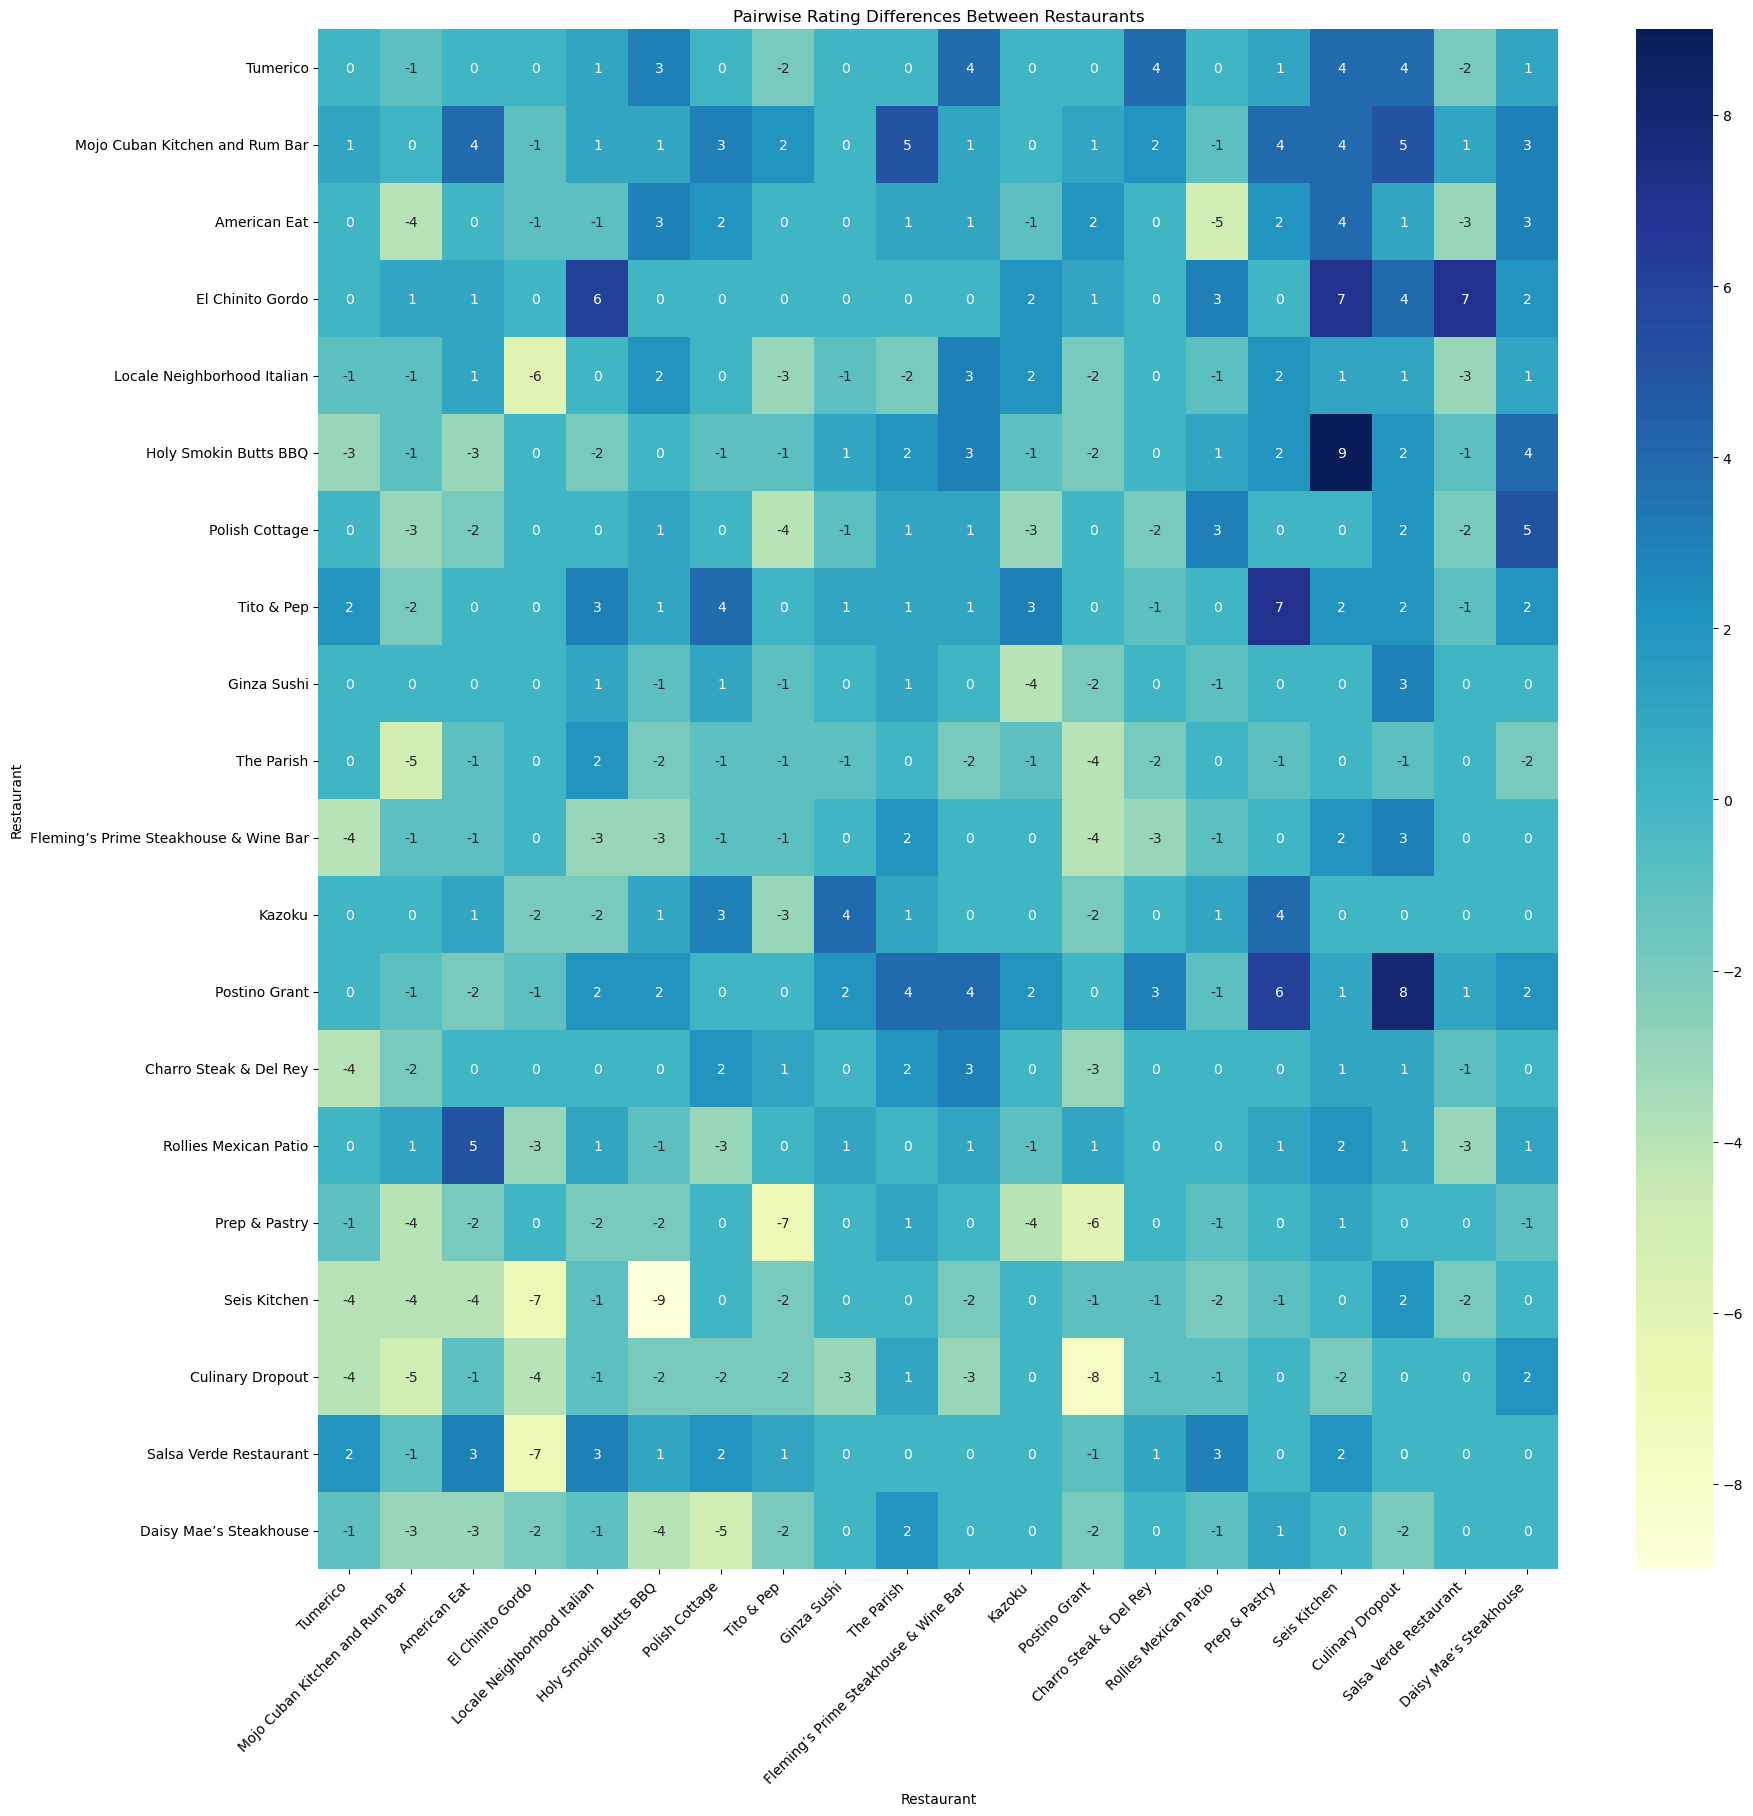

[ 0. -1.  0.  0.  1.  3.  0. -2.  0.  0.  4.  0.  0.  4.  0.  1.  4.  4.
 -2.  1.]
[ 1.  0.  4. -1.  1.  1.  3.  2.  0.  5.  1.  0.  1.  2. -1.  4.  4.  5.
  1.  3.]
[ 0. -4.  0. -1. -1.  3.  2.  0.  0.  1.  1. -1.  2.  0. -5.  2.  4.  1.
 -3.  3.]
[0. 1. 1. 0. 6. 0. 0. 0. 0. 0. 0. 2. 1. 0. 3. 0. 7. 4. 7. 2.]
[-1. -1.  1. -6.  0.  2.  0. -3. -1. -2.  3.  2. -2.  0. -1.  2.  1.  1.
 -3.  1.]
[-3. -1. -3.  0. -2.  0. -1. -1.  1.  2.  3. -1. -2.  0.  1.  2.  9.  2.
 -1.  4.]
[ 0. -3. -2.  0.  0.  1.  0. -4. -1.  1.  1. -3.  0. -2.  3.  0.  0.  2.
 -2.  5.]
[ 2. -2.  0.  0.  3.  1.  4.  0.  1.  1.  1.  3.  0. -1.  0.  7.  2.  2.
 -1.  2.]
[ 0.  0.  0.  0.  1. -1.  1. -1.  0.  1.  0. -4. -2.  0. -1.  0.  0.  3.
  0.  0.]
[ 0. -5. -1.  0.  2. -2. -1. -1. -1.  0. -2. -1. -4. -2.  0. -1.  0. -1.
  0. -2.]
[-4. -1. -1.  0. -3. -3. -1. -1.  0.  2.  0.  0. -4. -3. -1.  0.  2.  3.
  0.  0.]
[ 0.  0.  1. -2. -2.  1.  3. -3.  4.  1.  0.  0. -2.  0.  1.  4.  0.  0.
  0.  0.]
[ 0. -1. -2. -1.  2.  2. 

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

def get_index(restaurant):
    return restaurants.index(restaurant)

restaurants = set()
for business in allBusiness:
    restaurants.add(business.name)
restaurants = list(restaurants)
print(restaurants)
n = len(restaurants)
matrix = np.zeros((n, n))

for ratings in bigDict.values():
    for i in range(len(ratings)):
        for j in range(i + 1, len(ratings)):
            rest1, rating1 = ratings[i]
            rest2, rating2 = ratings[j]
            index1 = get_index(rest1)
            index2 = get_index(rest2)
            rating_diff = int(rating1) - int(rating2)
            if rating_diff > 0:
                matrix[index1][index2] += rating_diff
                matrix[index2][index1] -= rating_diff
            elif rating_diff < 0:
                matrix[index1][index2] += rating_diff  # negative decrement
                matrix[index2][index1] -= rating_diff

plt.figure(figsize=(20,20)) 
sns.heatmap(matrix, annot=True, cmap="YlGnBu", xticklabels=restaurants, yticklabels=restaurants)
plt.title('Pairwise Rating Differences Between Restaurants')
plt.xlabel('Restaurant')
plt.ylabel('Restaurant')
plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0) 
plt.show()


# aggregateRatings = defaultdict(list)
# for ratings in bigDict.values():
#     for restaurant, rating in ratings:
#         aggregateRatings[restaurant].append(int(rating))
# agScore = {}
# for restaurant, ratings in aggregateRatings.items():
#     avg = np.mean(ratings)
#     # np.median(ratings) ## median (duh)
#     agScore[restaurant] = avg
    
# for restaurant, score in sorted(agScore.items(), key=lambda item: item[1], reverse=True):
#     print(f"{restaurant}: {score:.2f}")

for line in matrix:
    print(line)


WINNER IS: El Chinito Gordo


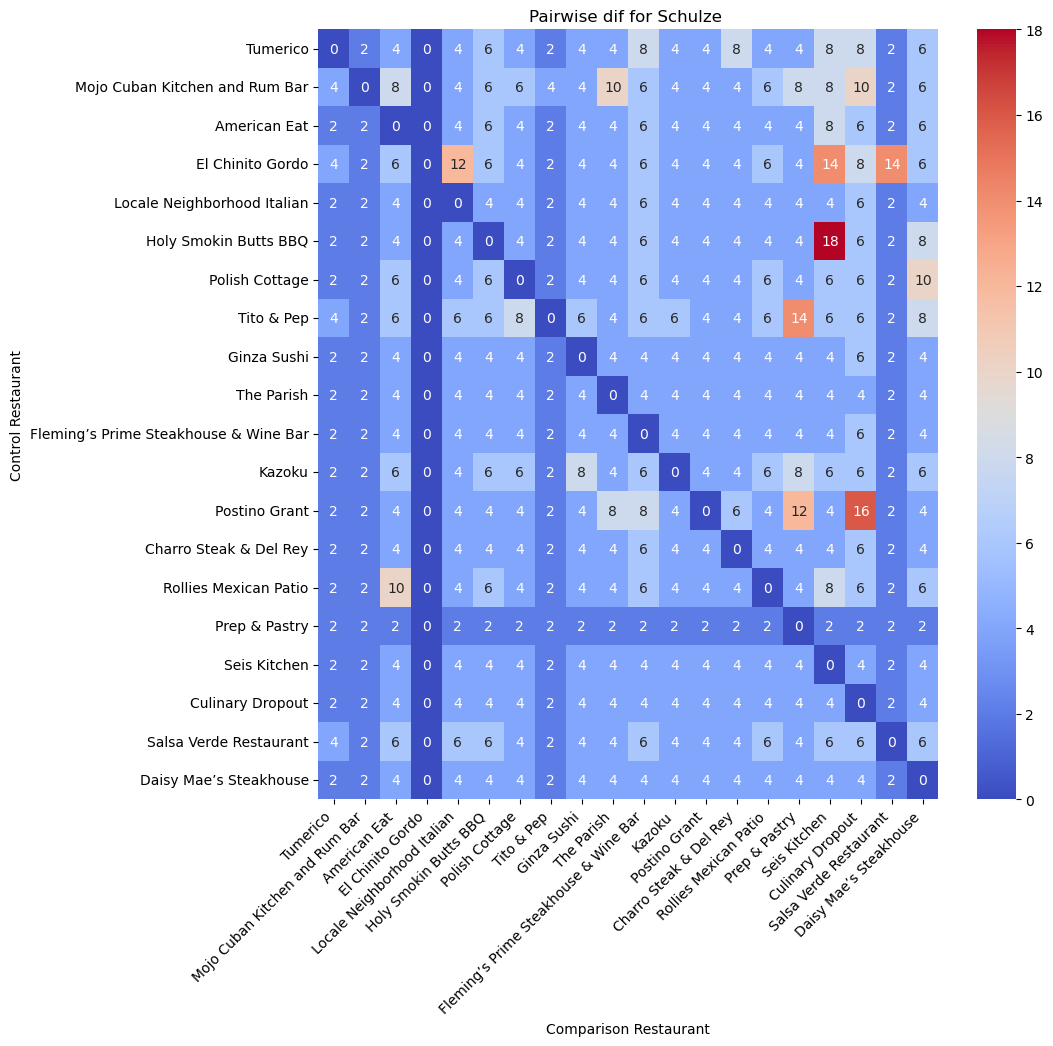

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

#SCHUZLE METHOD

nc = len(matrix)
pm = [[0] * nc for _ in range(nc)]

for i in range(nc):
    for j in range(nc):
        if i != j:
            if matrix[i][j] > matrix[j][i]:
                pm[i][j] = matrix[i][j] - matrix[j][i]
            else:
                pm[i][j] = 0
for i in range(nc):
    for j in range(nc):
        if i != j:
            for k in range(nc):
                if i != k and j != k:
                    pm[j][k] = max(pm[j][k], min(pm[j][i], pm[i][k]))

for i in range(nc):
    hasLost = False
    for j in range(nc):
        if i != j:
            if pm[i][j] <= pm[j][i]:
                hasLost = True
                break
    if not hasLost:
        print("WINNER IS:", restaurants[i])


        
plt.figure(figsize=(10,10)) 
sns.heatmap(pm, annot=True, cmap="coolwarm", xticklabels=restaurants, yticklabels=restaurants)
plt.title('Pairwise dif for Schulze ')
plt.xlabel('Comparison Restaurant')
plt.ylabel('Control Restaurant')
plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0) 
plt.show()
    

In [1]:
import numpy as np

def condorcet_winner(matrix, restaurants):
    n = len(matrix)
    candidate_is_condorcet = True
    for i in range(n):
        candidate_is_condorcet = True  # Assume candidate i is the Condorcet winner
        for j in range(n):
            if i != j:
                # Check if candidate i wins against candidate j
                if matrix[i][j] <= matrix[j][i]:
                    candidate_is_condorcet = False
                    break
        if candidate_is_condorcet:
            return f"The Condorcet winner is {restaurants[i]}"
    return "There is no Condorcet winner."

def copeland_scores(matrix, restaurants):
    n = len(matrix)
    scores = {}
    for i in range(n):
        wins = 0
        losses = 0
        for j in range(n):
            if i != j:
                if matrix[i][j] > matrix[j][i]:
                    wins += 1
                elif matrix[i][j] < matrix[j][i]:
                    losses += 1
        scores[restaurants[i]] = wins - losses
    return scores

condorcet_result = condorcet_winner(matrix, restaurants)
copeland_result = copeland_scores(matrix, restaurants)

print(condorcet_result)
    
cw = max(copeland_result, key=lambda k: copeland_result[k])

print("Copeland Winner: ", cw)
print("Copeland Winner Score: ",copeland_result[cw])

NameError: name 'matrix' is not defined